In [1]:
""""
Figaro times collection times script. 
"""
import numpy as np
import os
import pandas as pd 
from openpyxl import load_workbook, Workbook
from openpyxl.utils.cell import get_column_letter

path_src = "/local/scratch/Figaro/figaro-code"
exp_names = ["figaro", "mkl"]
exp_paths = {"figaro": "comparisons/performance/figaro", "mkl": "comparisons/performance/python/numpy"}
xlsx_name = "time.xlsx"
num_measurement = 5

column_nums = [64, 256, 1024, 4096]
row_nums = [512, 1024, 2048, 4096, 8192]
row_col_nums = []

skip_dbs = {"mkl": [11, 12, 13, 14, 15, 16, 17, 18, 19, 20], "figaro": []}
#skip_dbs = {"mkl": [12, 15, 16, 18, 19, 20], "figaro": []}

for row_num in row_nums:
    for col_num in column_nums:
        row_col_nums.append((row_num, col_num))

df_measurement_exps = {}

for exp_name in exp_names:
    #Initialize paths for the current experiment 
    exp_path = exp_paths[exp_name]
    perf_path = os.path.join(path_src, exp_path)
    df_measurement = pd.DataFrame(columns=column_nums)
    gather_times_path = os.path.join(perf_path, xlsx_name)

    out_workbook = Workbook()
    out_workbook.remove(out_workbook.active)
    out_sheet = out_workbook.create_sheet("Times")

    for db_idx, db_num in enumerate(range(1, 21)): 
        db_name = "DBCartesianProduct{}".format(db_num)
        if db_num in skip_dbs[exp_name]:
            continue
        path_xlsx = os.path.join(perf_path, db_name, xlsx_name)
        print(path_xlsx)
        workbook = load_workbook(filename=path_xlsx)
        sheet = workbook.active
        row_count = sheet.max_row

        col_idx = db_idx + 1
        col_letter = get_column_letter(col_idx)
        
        # Writng header files
        out_sheet.cell(row=1, column=col_idx).value = db_name

        # Collecting average. 
        start_row_idx = 2
        np_measures = np.zeros(num_measurement)
        for row_idx_dst in range(start_row_idx, start_row_idx + num_measurement):
            offset_idx = row_idx_dst - start_row_idx
            row_idx_src = row_count - num_measurement  + offset_idx
            val = sheet.cell(row=row_idx_src, column=2).value
            np_measures[offset_idx] = float(val)
            #print(idx_shift, db_idx)
            out_sheet.cell(row=row_idx_dst, column=col_idx).value = val

        time_avg = np.mean(np_measures[1:])
        row_num = row_col_nums[db_idx][0]
        col_num = row_col_nums[db_idx][1]
        df_measurement.at[row_num, col_num] = time_avg

    out_workbook.save(gather_times_path)
    df_measurement = df_measurement.astype(float)
    df_measurement_exps[exp_name] = df_measurement


df_measurement_speed_up = df_measurement_exps["mkl"] / df_measurement_exps["figaro"]


/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBCartesianProduct1/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBCartesianProduct2/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBCartesianProduct3/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBCartesianProduct4/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBCartesianProduct5/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBCartesianProduct6/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBCartesianProduct7/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBCartesianProduct8/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBCartesianProduct9/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBCartesianProduct10/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/per

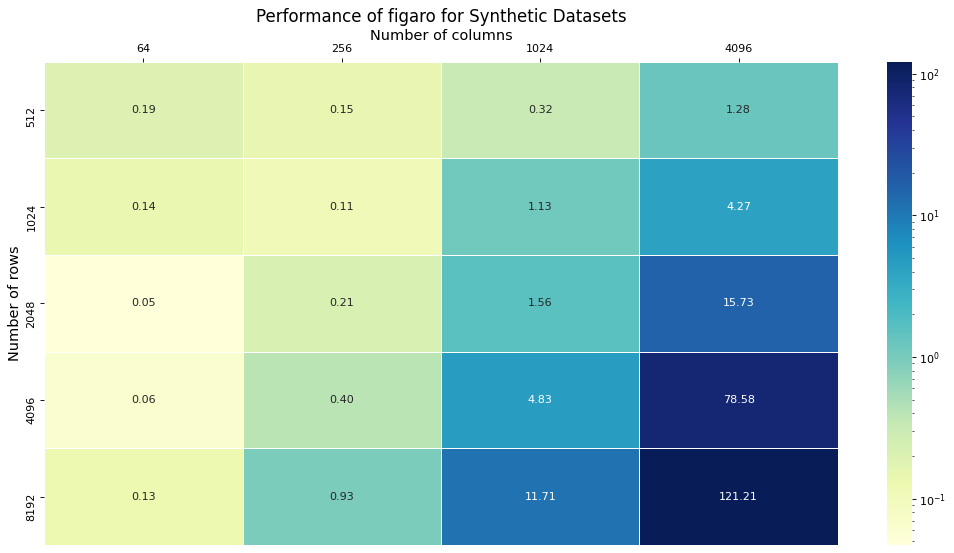

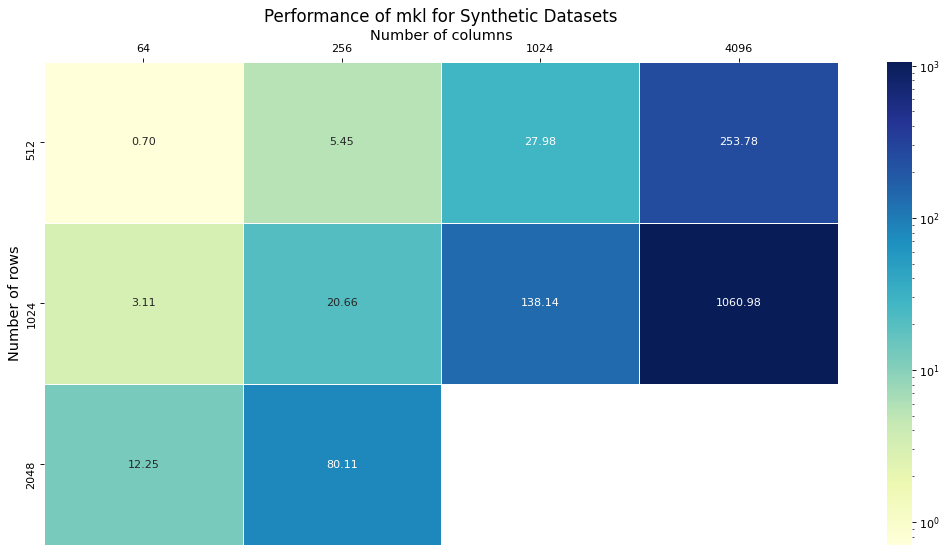

NameError: name 'df_measurement_speed_up' is not defined

<Figure size 1280x640 with 0 Axes>

In [2]:
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

for exp_name in exp_names:
    plt.figure(exp_name, figsize=(16, 8), dpi=80)
    df_measurement = df_measurement_exps[exp_name]
    ax = sns.heatmap(df_measurement, linewidth=0.5, annot=True, fmt='.2f', cmap="YlGnBu", norm=LogNorm())

    ax.set_ylabel("Number of rows", fontsize=13)
    ax.set_xlabel("Number of columns", fontsize=13)
    ax.set_title("Performance of {} for Synthetic Datasets".format(exp_name), fontsize=15)
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position("top")
    plt.savefig("exp1syn{}.pdf".format(exp_name),bbox_inches='tight')


plt.show()

plt.figure("Speed up", figsize=(16, 8), dpi=80)
df_measurement = df_measurement_speed_up
ax = sns.heatmap(df_measurement, linewidth=0.5, annot=True, fmt='.2f', cmap="YlGnBu", norm=LogNorm())

ax.set_ylabel("Number of rows", fontsize=13)
ax.set_xlabel("Number of columns", fontsize=13)
ax.set_title("Speed up of Figaro over MKL for Synthetic Datasets", fontsize=15)
ax.xaxis.set_ticks_position('top') 
ax.xaxis.set_label_position("top")
plt.savefig("exp1synSpeedUp.pdf",bbox_inches='tight')
ax.set_facecolor('black')

